In [46]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle
import wrds

In [47]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [48]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [49]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [50]:
unneeded_columns = ["ticker","year","quarter","gsector","gicdesc","y"]

In [174]:
market.connect()
sec.connect()
factors_df = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("financials",{"ticker":ticker})).drop(["gsector","gicdesc"],axis=1)
        filings["year"] = [x.year for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["quarter"] = filings["quarter"].shift(1)
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","ticker"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-1)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()

  4%|████████▋                                                                                                                                                                                               | 22/503 [00:02<00:58,  8.26it/s]

GOOGL 'date'


 11%|█████████████████████▍                                                                                                                                                                                  | 54/503 [00:06<00:50,  8.95it/s]

AVB 'date'


 13%|█████████████████████████▍                                                                                                                                                                              | 64/503 [00:07<00:41, 10.63it/s]

BRK.B 'date'


 16%|███████████████████████████████▍                                                                                                                                                                        | 79/503 [00:09<00:38, 10.99it/s]

BF.B 'date'


 16%|████████████████████████████████▏                                                                                                                                                                       | 81/503 [00:09<00:38, 10.94it/s]

BXP 'date'


 18%|████████████████████████████████████▏                                                                                                                                                                   | 91/503 [00:10<00:37, 10.90it/s]

CCL 'date'


 26%|████████████████████████████████████████████████████▏                                                                                                                                                  | 132/503 [00:14<00:35, 10.36it/s]

CPAY 'date'


 29%|████████████████████████████████████████████████████████▉                                                                                                                                              | 144/503 [00:16<00:33, 10.57it/s]

DAY 'date'


 30%|████████████████████████████████████████████████████████████▏                                                                                                                                          | 152/503 [00:16<00:33, 10.38it/s]

DLR 'date'


 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                               | 180/503 [00:20<00:36,  8.88it/s]

EQR 'date'
ESS 'date'


 37%|████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 184/503 [00:20<00:28, 11.32it/s]

EG 'date'


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 195/503 [00:21<00:32,  9.61it/s]

FRT 'date'


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 214/503 [00:23<00:23, 12.50it/s]

GEV 'date'


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 263/503 [00:28<00:20, 11.68it/s]

IVZ 'date'
INVH 'date'


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 269/503 [00:29<00:23,  9.91it/s]

JCI 'date'


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 280/503 [00:30<00:20, 11.00it/s]

KIM 'date'


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 299/503 [00:32<00:19, 10.60it/s]

LYB 'date'


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 323/503 [00:35<00:16, 11.06it/s]

MAA 'date'


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 349/503 [00:38<00:15,  9.65it/s]

NCLH 'date'


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 354/503 [00:38<00:14, 10.23it/s]

NXPI 'date'


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 399/503 [00:43<00:10,  9.50it/s]

REG 'date'


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 409/503 [00:44<00:09,  9.74it/s]

RCL 'date'


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 413/503 [00:45<00:09,  9.95it/s]

SLB 'date'


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 460/503 [00:50<00:03, 11.21it/s]

UDR 'date'


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 472/503 [00:51<00:02, 11.09it/s]

VLTO 'date'


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 477/503 [00:51<00:02, 12.69it/s]

VICI 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:54<00:00,  9.19it/s]

ZBRA 'date'
ZBH 'date'
ZTS 'date'


In [175]:
factors_df = pd.concat(factors_df)

In [176]:
for column in factors_df:
    if column in factors_df[column]:
        factors_df.drop(column,axis=1,inplace=True)

In [177]:
factors_df = factors_df.fillna(0)

In [178]:
factors_df[[x for x in factors_df.columns if x not in unneeded_columns]].corr()[["adjclose"]].sort_values("adjclose").tail(20)

,adjclose
pe_inc,0.051648
pe_exi,0.052277
gprof,0.052678
aftret_invcapx,0.054780
roe,0.055838
mktcap,0.056037
accrual,0.057959
divcash,0.068816
pcf,0.072457
roa,0.074286


In [179]:
for column in factors_df.columns:
    print(column)

year
quarter
close
high
low
open
volume
adjclose
adjhigh
adjlow
adjopen
adjvolume
divcash
splitfactor
capei
be
bm
evm
pe_exi
pe_inc
ps
pcf
dpr
npm
opmbd
opmad
gpm
ptpm
cfm
roa
roe
roce
efftax
aftret_eq
aftret_invcapx
aftret_equity
pretret_noa
pretret_earnat
gprof
equity_invcap
debt_invcap
totdebt_invcap
capital_ratio
int_debt
int_totdebt
cash_lt
invt_act
rect_act
debt_at
debt_ebitda
short_debt
curr_debt
lt_debt
profit_lct
ocf_lct
cash_debt
fcf_ocf
lt_ppent
dltt_be
debt_assets
debt_capital
de_ratio
intcov
intcov_ratio
cash_ratio
quick_ratio
curr_ratio
cash_conversion
inv_turn
at_turn
rect_turn
pay_turn
sale_invcap
sale_equity
sale_nwc
rd_sale
adv_sale
staff_sale
accrual
ret_crsp
mktcap
price
ptb
peg_trailing
divyield
ticker
y


In [180]:
model = XGBRegressor()
factors = ["pe_exi","ptb","roa","mktcap","adjclose"]
factors_df.sort_values(["year","quarter"],inplace=True)
training_data = factors_df[(factors_df["year"]>2013) & (factors_df["year"]<2020)].dropna()
sim = factors_df[factors_df["year"]>=2020].drop("y",axis=1).dropna()
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

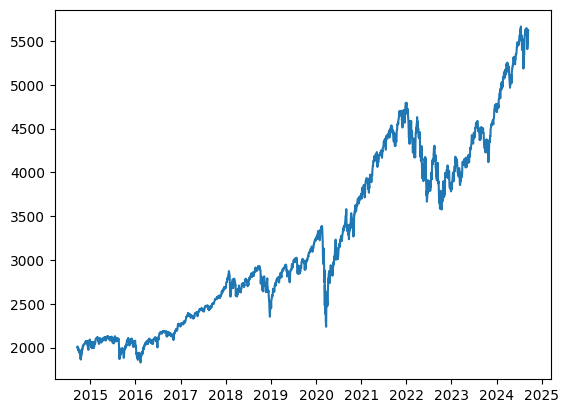

In [181]:
plt.plot(spy["date"].values,spy["spy"].values)
plt.show()

In [182]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["historical_return"] = price["adjclose"].pct_change(90)
        price["factor_return"] = price["spy"].pct_change(90)
        price["cov"] = price["factor_return"].rolling(100).cov(price["historical_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["historical_return"] - price["rf"])
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

 13%|█████████████████████████▊                                                                                                                                                                              | 65/503 [00:05<00:35, 12.36it/s]

BRK.B 'date'


 16%|███████████████████████████████▊                                                                                                                                                                        | 80/503 [00:06<00:31, 13.56it/s]

BF.B 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:42<00:00, 11.85it/s]

ZBRA 'date'
ZBH 'date'
ZTS 'date'


In [183]:
sim = pd.concat(prices).dropna()
sim["quarter"] = [x.quarter for x in sim["date"]]

In [198]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 5
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
        }
        for _ in sp500["GICS Sector"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    prev_quarter = quarter
    quarter = date.quarter
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        notional = stock["pv"]
                        hpr = int((date - stock["buy_date"]).days)
                        opportunity_row = today[today["GICS Sector"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (hpr > 90):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional)
                            stock["sector"] = sector
                            position["stocks"][j] = stock
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today[today["GICS Sector"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional)
                        stock["sector"] = sector
                        position["stocks"][j] = stock
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

Error on date 2022-04-06 00:00:00: single positional indexer is out-of-bounds
Error on date 2022-04-07 00:00:00: single positional indexer is out-of-bounds


In [199]:
performance

,date,pv,stock_return
0,2020-01-02,1.000000e+05,0.000000
1,2020-01-03,1.000632e+05,0.000632
2,2020-01-06,9.989622e+04,-0.001038
3,2020-01-07,1.003262e+05,0.003262
4,2020-01-08,1.014496e+05,0.014496
...,...,...,...
1170,2024-09-06,1.439832e+06,13.398322
1171,2024-09-09,1.459152e+06,13.591522
1172,2024-09-10,1.458063e+06,13.580629
1173,2024-09-11,1.454828e+06,13.548276


In [200]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [201]:
performance = pd.DataFrame(portfolios).dropna()
performance = performance.groupby(["date","sector"]).agg({"pv":"sum"}).reset_index()
performance["stock_return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

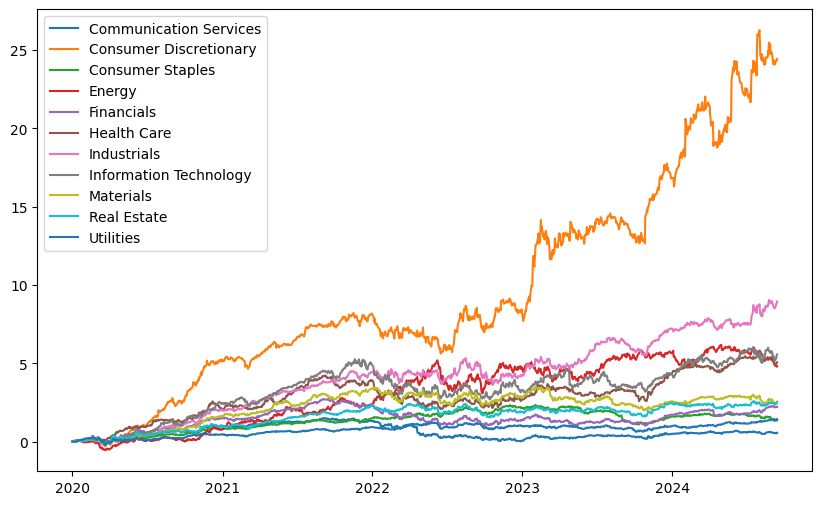

In [202]:
plt.figure(figsize=(10, 6))  
for sector in performance["sector"].unique():
    sector_perf = performance[performance["sector"]==sector]
    plt.plot(sector_perf["date"].values,sector_perf["stock_return"].values)
    plt.legend(performance["sector"].unique())
plt.show()

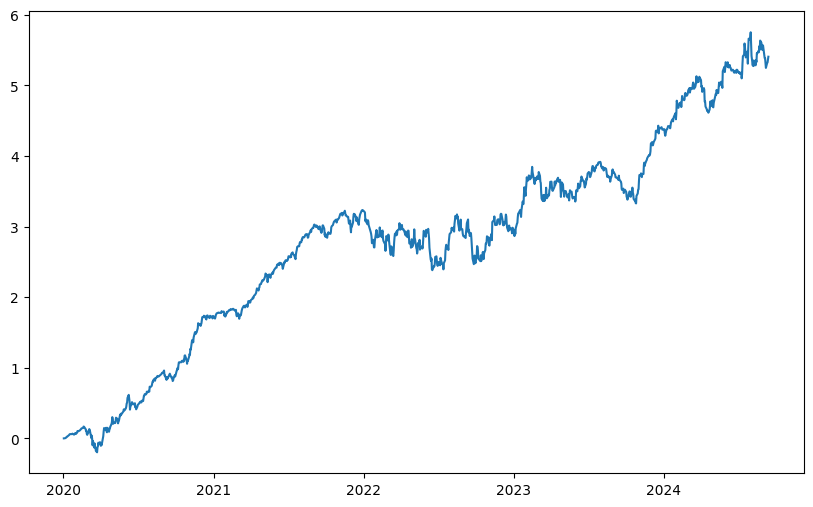

In [203]:
performance = performance.groupby(["date"]).agg({"pv":"sum"}).reset_index()
performance["stock_return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]
plt.figure(figsize=(10, 6)) 
plt.plot(performance["date"].values,performance["stock_return"].values)
plt.show()

In [204]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [205]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

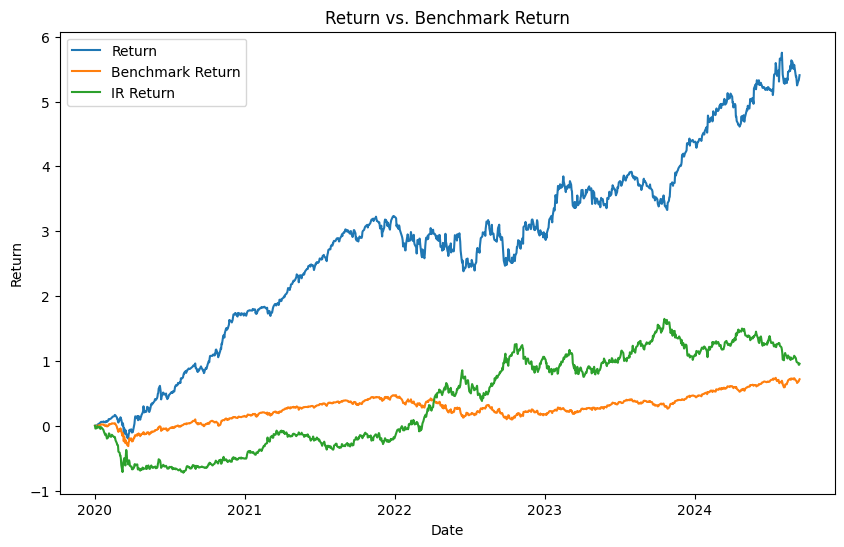

In [206]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [207]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

3.241791772185006

In [208]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [209]:
t.sort_values("return",ascending=False).head(30)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,sector,GICS Sector,return,hpr
85,CZR,41.200000,179.989487,-1.107367,10.670000,2020-04-02,2020-07-02,7415.566853,Consumer Discretionary,Consumer Discretionary,2.861293,91
86,ETSY,110.680000,40.234163,-0.340697,34.800000,2020-04-02,2020-07-02,4453.117142,Consumer Discretionary,Consumer Discretionary,2.180460,91
106,TRGP,17.526235,58.796487,-1.195550,5.763905,2020-04-02,2020-07-02,1030.481055,Energy,Energy,2.040688,91
105,APA,12.286883,271.443424,-1.592030,4.333173,2020-04-02,2020-07-02,3335.193722,Energy,Energy,1.835540,91
87,TSLA,80.577333,36.447161,2.861990,30.298000,2020-04-02,2020-07-02,2936.815057,Consumer Discretionary,Consumer Discretionary,1.659493,91
140,BBWI,25.337717,643.445892,4.214220,11.524771,2020-07-02,2020-10-01,16303.450091,Consumer Discretionary,Consumer Discretionary,1.198544,91
176,ENPH,175.470000,68.035838,-1.412329,89.510000,2020-10-01,2020-12-31,11938.248562,Information Technology,Information Technology,0.960340,91
195,TPR,28.064062,1135.567269,-4.018254,14.357098,2020-10-01,2020-12-31,31868.630743,Consumer Discretionary,Consumer Discretionary,0.954717,91
215,TRGP,24.526505,266.015703,3.438130,12.547478,2020-10-01,2020-12-31,6524.435364,Energy,Energy,0.954696,91
75,PYPL,177.210000,20.201012,0.466226,93.520000,2020-04-02,2020-07-02,3579.821382,Financials,Financials,0.894889,91


In [210]:
t.groupby(["GICS Sector"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return").tail(50)

,GICS Sector,return,hpr
0,Communication Services,0.045902,91.0
10,Utilities,0.047519,91.0
2,Consumer Staples,0.059221,91.0
9,Real Estate,0.076454,91.0
4,Financials,0.077473,91.0
8,Materials,0.088342,91.0
5,Health Care,0.110738,91.0
7,Information Technology,0.129475,91.0
6,Industrials,0.150835,91.0
3,Energy,0.152240,91.0
